### Target - Age

* For a commercial crab farmer knowing the right age of the crab helps them decide if and when to harvest the crabs. Beyond a certain age, there is negligible growth in crab's physical characteristics and hence, it is important to time the harvesting to reduce cost and increase profit.

* The quality of the meat is also an important factor in determining the optimal harvesting age. King crabs that are harvested too young may have less meat and a lower quality of meat than those that are harvested at the optimal age. The meat of mature king crabs is firmer and sweeter than that of younger crabs, which makes it more desirable to consumers.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from termcolor import colored
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error
from sklearn import model_selection, metrics
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from lightgbm import LGBMRegressor as lgb
import optuna
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay
import warnings
warnings.filterwarnings("ignore")

# data loading

In [3]:
train = pd.read_csv("C:/Users/Nasem/Downloads/crabsdata/train.csv")
original = pd.read_csv("C:/Users/Nasem/Downloads/crabsdata/CrabAgePrediction (2).csv")
test = pd.read_csv("C:/Users/Nasem/Downloads/crabsdata/test.csv")
sample_submission = pd.read_csv("C:/Users/Nasem/Downloads/crabsdata/sample_submission (1).csv")


In [4]:
train.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [5]:
original.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,F,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6
2,I,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6
3,F,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10
4,I,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6


In [6]:
count = [col for col in train.columns if train[col].dtype == 'object']
count_values = [train[col].nunique() for col in count]

print("Categorical Columns:")
for col, count_value in zip(count, count_values):
    print(f"- {col}: {count_value}")

numeric_cols = [col for col in train.columns if train[col].dtype != 'object']

print("\nNumeric Columns:")
for col in numeric_cols:
    print(f"- {col}")

Categorical Columns:
- Sex: 3

Numeric Columns:
- id
- Length
- Diameter
- Height
- Weight
- Shucked Weight
- Viscera Weight
- Shell Weight
- Age


# EDA

In [7]:
num_rows, num_cols = train.shape
print(f"DataFrame Dimensions:\nNumber of rows: {num_rows}\nNumber of columns: {num_cols}\n")
print("DataFrame Summary:")
train.info()

DataFrame Dimensions:
Number of rows: 74051
Number of columns: 10

DataFrame Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74051 entries, 0 to 74050
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              74051 non-null  int64  
 1   Sex             74051 non-null  object 
 2   Length          74051 non-null  float64
 3   Diameter        74051 non-null  float64
 4   Height          74051 non-null  float64
 5   Weight          74051 non-null  float64
 6   Shucked Weight  74051 non-null  float64
 7   Viscera Weight  74051 non-null  float64
 8   Shell Weight    74051 non-null  float64
 9   Age             74051 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 5.6+ MB


# Statistical summary

In [8]:
desc = train.describe().T
desc['nunique'] = train.nunique()
desc['%unique'] = desc['nunique'] / len(train) * 100
desc['null'] = train.isna().sum()
desc['type'] = train.dtypes
desc.head(60)

,count,mean,std,min,25%,50%,75%,max,nunique,%unique,null,type
id,74051.0,37025.000000,21376.826729,0.000000,18512.500000,37025.000000,55537.500000,74050.000000,74051,100.000000,0,int64
Length,74051.0,1.317460,0.287757,0.187500,1.150000,1.375000,1.537500,2.012815,144,0.194461,0,float64
Diameter,74051.0,1.024496,0.237396,0.137500,0.887500,1.075000,1.200000,1.612500,122,0.164751,0,float64
Height,74051.0,0.348089,0.092034,0.000000,0.300000,0.362500,0.412500,2.825000,65,0.087777,0,float64
Weight,74051.0,23.385217,12.648153,0.056699,13.437663,23.799405,32.162508,80.101512,3096,4.180902,0,float64
Shucked Weight,74051.0,10.104270,5.618025,0.028349,5.712424,9.908150,14.033003,42.184056,1766,2.384843,0,float64
Viscera Weight,74051.0,5.058386,2.792729,0.042524,2.863300,4.989512,6.988152,21.545620,967,1.305857,0,float64
Shell Weight,74051.0,6.723870,3.584372,0.042524,3.968930,6.931453,9.071840,28.491248,1048,1.415241,0,float64
Age,74051.0,9.967806,3.175189,1.000000,8.000000,10.000000,11.000000,29.000000,28,0.037812,0,int64


### Weight 
weight has an average of 23.39 units, with a minimum of 0.06 and a maximum of 80.10. It exhibits a higher standard deviation (12.65), indicating  a wider spread of values.

### Age 
 Age is our target and it represents the age of the crabs  . It has a mean of 9.97 years, ranging from 1 to 29. It has small number of unique values (28).

### Missing Values:

There are no missing values (null) present in the dataset for any of the variables.

In [9]:
age_count = train.groupby('Age').size().rename('count').reset_index()
age_count

,Age,count
0,1,16
1,2,14
2,3,213
3,4,948
4,5,1913
5,6,4532
6,7,6574
7,8,9966
8,9,12473
9,10,11480


# Target Distribution

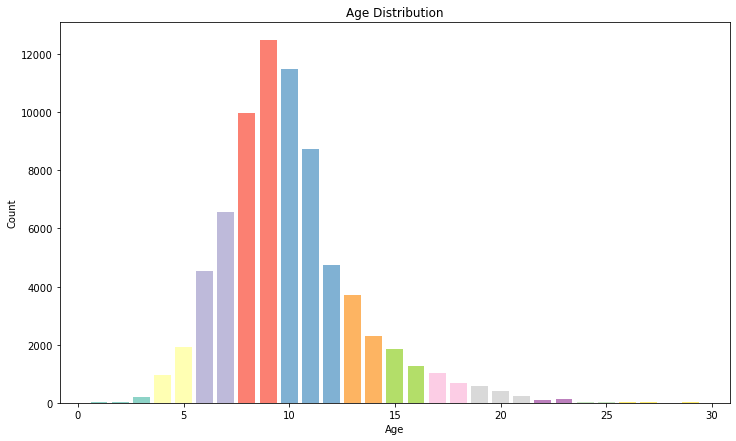

In [37]:
import numpy as np

def create_bar_plot(data, x, y, title, xaxis_title, yaxis_title):
    plt.figure(figsize=(12, 7))
    
    # Generate a color palette with a unique color for each bar
    num_bars = len(data[x])
    colors = plt.cm.Set3(np.linspace(0, 1, num_bars))
    
    plt.bar(data[x], data[y], color=colors)
    plt.title(title)
    plt.xlabel(xaxis_title)
    plt.ylabel(yaxis_title)
    plt.show()

age_count = train.groupby('Age').size().rename('count').reset_index()

create_bar_plot(age_count, 'Age', 'count', 'Age Distribution', 'Age', 'Count')



### Insights
* most of the crabs are between 6 to 13 years of age

* In general, most crab species are harvested when they are between 5 and 11 years old. At this age, they have had a chance to reproduce, and their meat is still tender and flavorful. However, some species, such as the red king crab, may be harvested at a younger age, as they grow faster and reach maturity earlier than other species.

# Correlations

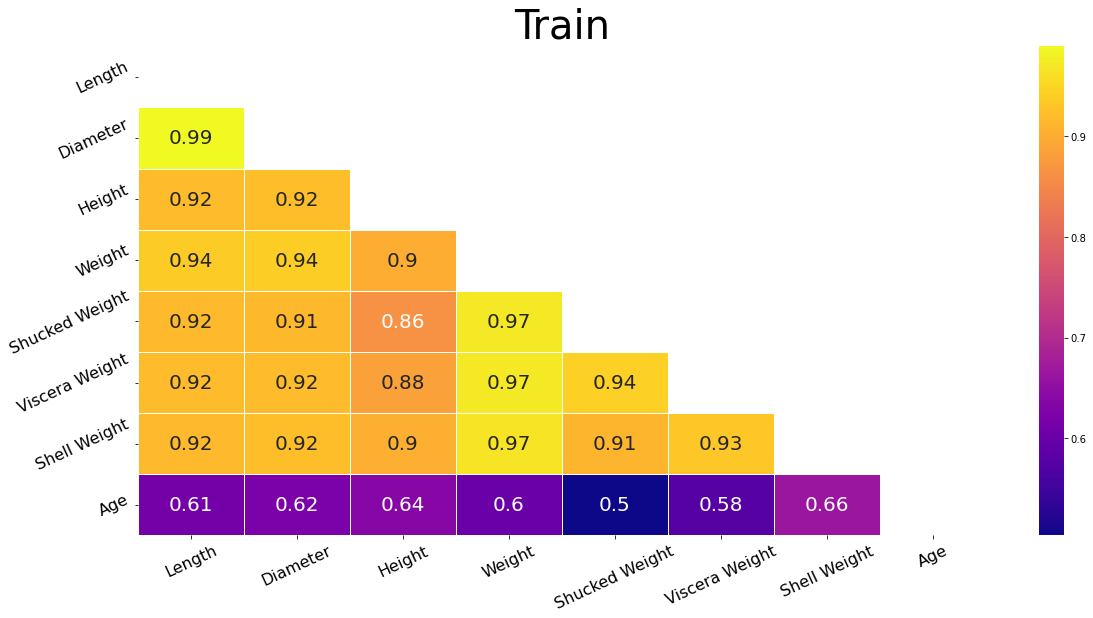

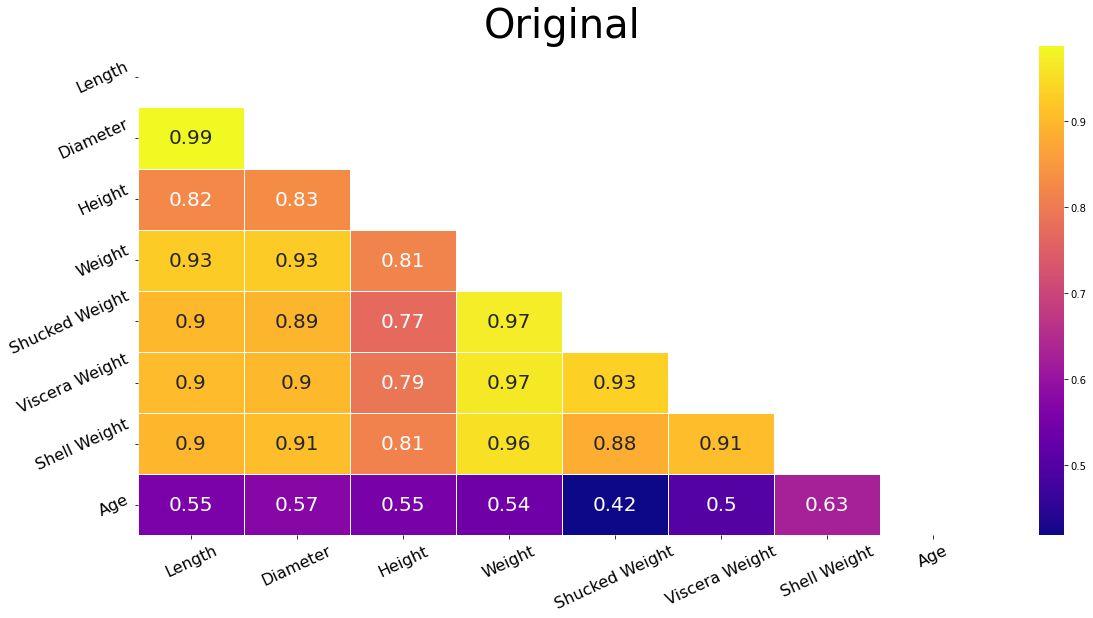

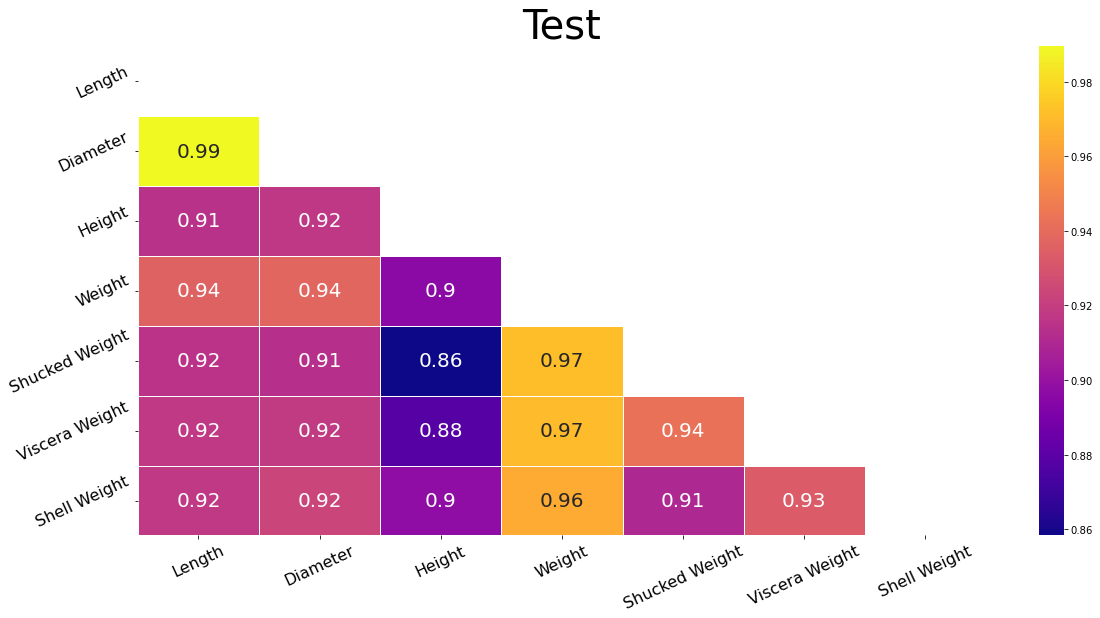

In [11]:
def heatmap(dataset, title):
    if title != 'Original':
        dataset_ = dataset.drop('id', axis=1)
    else:
        dataset_ = dataset
    corr = dataset_.corr()
    fig, axes = plt.subplots(figsize=(19, 9))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, linewidths=0.5, mask=mask, cmap='plasma', annot=True, annot_kws={'size': 20})
    plt.title(title, fontsize=40)
    plt.xticks(fontsize=16, rotation=25)
    plt.yticks(fontsize=16, rotation=25)
    plt.show()

heatmap(train, 'Train')
heatmap(original, 'Original')
heatmap(test, 'Test')

### Age and Diameter:

* There is a moderate positive correlation between age and diameter (correlation coefficient = 0.621). and this also one of the most important feautures for the lgb model.



### Age and Shell weight: 
* Shell weight has strongest correlation with age amongst all features in train set and it also turn out to be most important feature for the lgb model

# Distribution of target variable

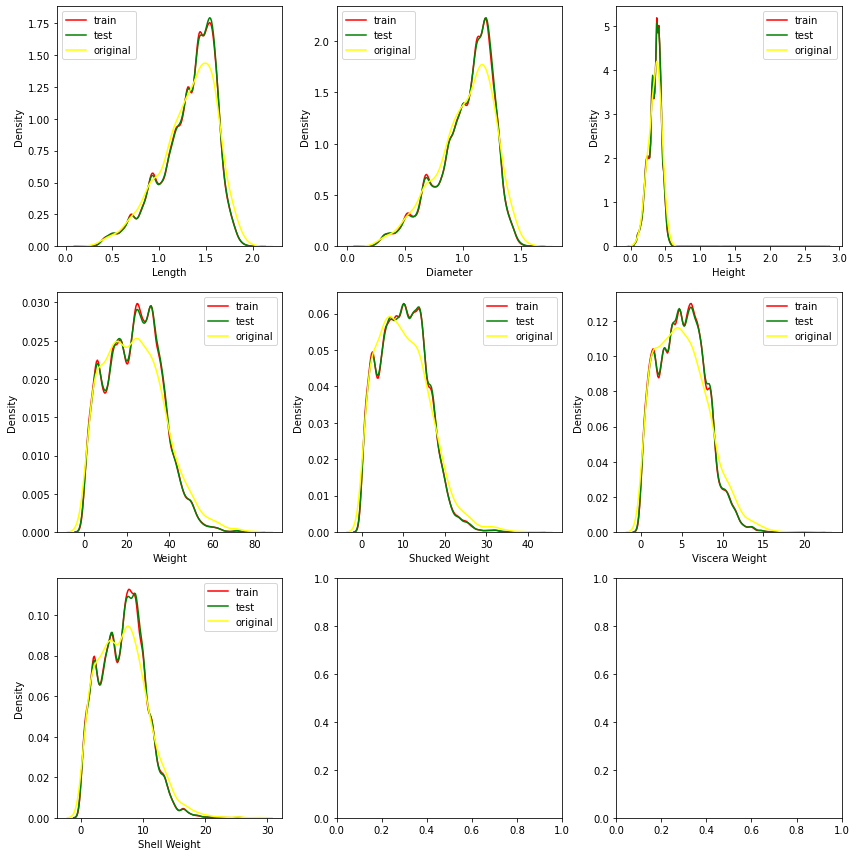

In [12]:
import math

def plot_distributions(train=None, test=None, original=None):
    train_data = train.drop(columns=['id', 'Age'], axis=1)
    test_data = test.drop(columns='id', axis=1)
    original_data = original.drop(columns='Age', axis=1)

    numerical_columns = train_data.select_dtypes(include=['float64', 'int64']).columns.tolist()

    num_plots = len(numerical_columns)
    num_rows = math.ceil(num_plots / 3)
    num_cols = min(num_plots, 3)

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 4 * num_rows))

    for ax, col in zip(axes.flatten(), numerical_columns):
        sns.kdeplot(train_data[col], ax=ax, color='red', label='train')
        sns.kdeplot(test_data[col], ax=ax, color='green', label='test')
        sns.kdeplot(original_data[col], ax=ax, color='yellow', label='original')
        ax.set_xlabel(col)
        ax.legend()

    plt.tight_layout()
    plt.show()


plot_distributions(train, test, original)


**as we can see there is almost same distribution for train, test and original dataset but the number of instance is lesser in original dataset**

# Distribution of features

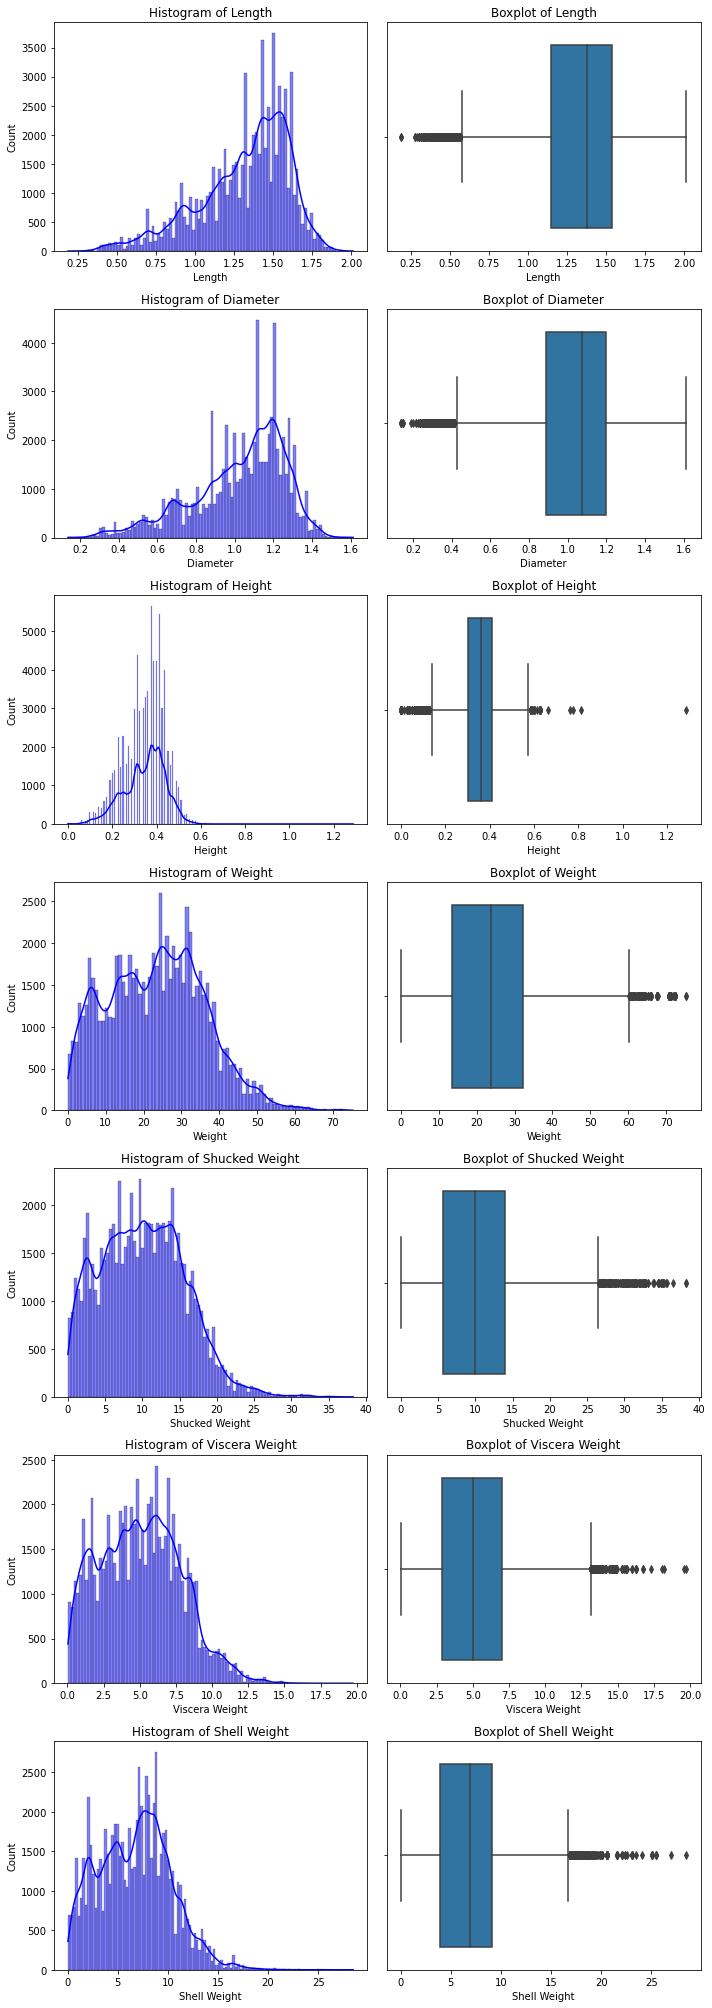

In [26]:
num_cols = test.select_dtypes(include=['float64']).columns.tolist()
num_cols_count = len(num_cols)
n_rows = num_cols_count

fig, axs = plt.subplots(n_rows, 2, figsize=(10, n_rows*4))

for idx, col in enumerate(num_cols):

    # Plot histogram
    sns.histplot(data=train, x=col, kde=True, ax=axs[idx, 0], color='blue')
    axs[idx, 0].set_title(f'Histogram of {col}')

    # Plot boxplot
    sns.boxplot(data=train, x=col, ax=axs[idx, 1])
    axs[idx, 1].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

# Train vs Test feature distribution

In [14]:
def plot_kde_plots(data, title=None):
    fig, axes = plt.subplots(2, 4, figsize=(10, 4))
    print(colored(f"\nKDE plot for {title}\n", color='red', attrs=['bold']))
    for i, col in enumerate(data.columns[2:9]):
        sns.kdeplot(data[col], ax=axes[i // 4, i % 4], color='tab:green', fill=True)
        axes[i // 4, i % 4].set(xlabel='', ylabel='')
        axes[i // 4, i % 4].set_title(f"\n{col}\n", fontsize=10, fontweight='bold', color='tab:red')

    plt.tight_layout()
    plt.show()



KDE plot for train



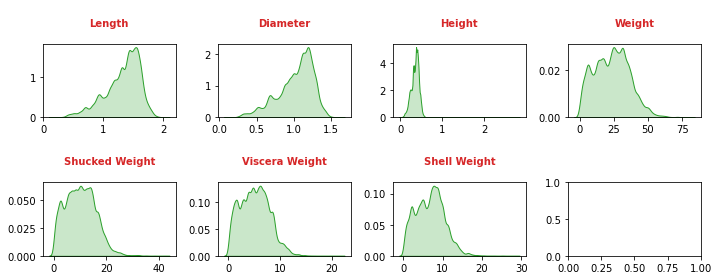


KDE plot for test



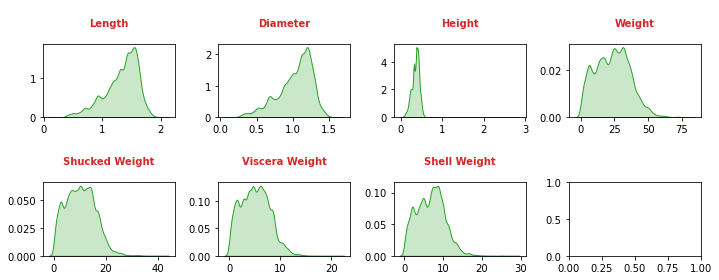

In [15]:
plot_kde_plots(train,'train')
plot_kde_plots(test,'test')

# Detecting outliers through violin plot

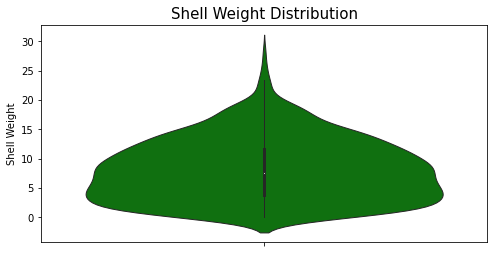

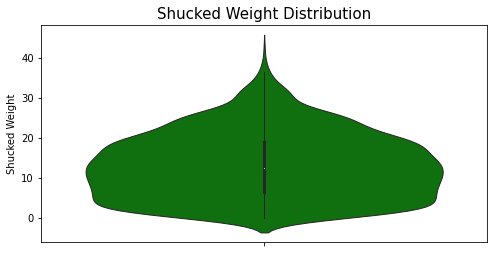

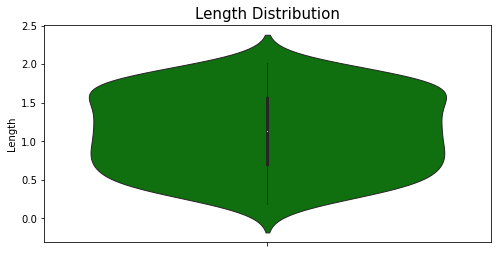

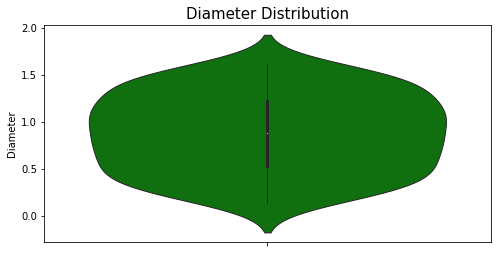

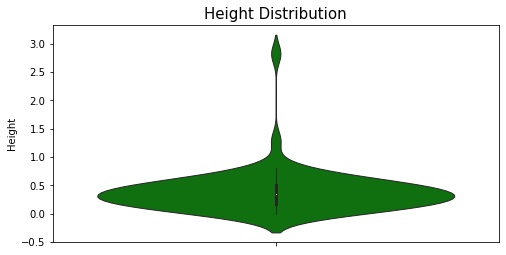

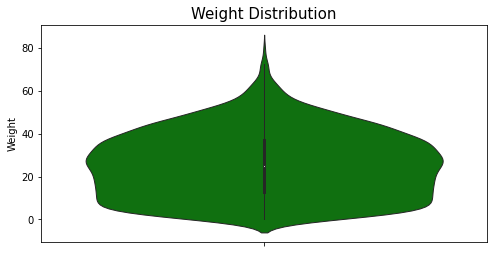

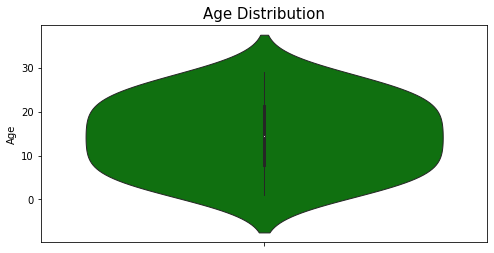

In [16]:
import matplotlib.pyplot as plt

def create_violin_plot(data, feature):
    plt.figure(figsize=(8, 4))
    sns.violinplot(data=data, y=feature, color='green', inner='box', linewidth=1)
    plt.title(f'{feature} Distribution', fontsize=15)
    plt.ylabel(feature)
    plt.show()

create_violin_plot(grouped_ShellWeight, 'Shell Weight')
create_violin_plot(grouped_ShuckedWeight, 'Shucked Weight')
create_violin_plot(grouped_Length, 'Length')
create_violin_plot(grouped_Diameter, 'Diameter')
create_violin_plot(grouped_Height, 'Height')
create_violin_plot(grouped_Weight, 'Weight')
create_violin_plot(grouped_Age, 'Age')


### Insights 
As we can see there are some outliers in
* Weight
* Height 
* Shucked Weight colum

And removing these does improve the model performance

# Removing outliers

In [17]:
train = train.drop(train[train['Height'] > 2.5].index)
train = train.drop(train[train['Weight'] > 78].index)
train = train.drop(train[train['Shucked Weight'] > 39].index)



In [18]:
train = pd.get_dummies(train, columns=['Sex'])
test = pd.get_dummies(test, columns=['Sex'])

# Defining and training model

In [19]:
x = train.copy().drop(["id", "Age"], axis=1)
y = train.copy()["Age"]

Test = test.copy().drop(["id",], axis=1)


In [20]:
feature_names=x.columns

In [21]:


def objective(trial):
    params = {
        'categorical_feature': [0],
        'task': 'predict',
        'application': 'regression',
        'objective': 'mae',
        'boosting_type': 'gbdt',
        'num_iterations': trial.suggest_int('num_iterations', 2600, 2700),
        'learning_rate': trial.suggest_float('learning_rate', 0.085, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 8, 10),
        'tree_learner': 'feature',
        'max_depth': trial.suggest_int('max_depth', 11, 13),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 9, 11),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.8, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 95, 100),
        'reg_sqrt': True,
        'metric': 'mae',
        'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 0.9),
        'random_state': 42
    }

    # Split the data into train and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

    # Train the model with the current set of hyperparameters
    model = lgb.LGBMRegressor(**params)
    model.fit(x_train, y_train)

    # Evaluate the model on the validation set
    y_pred = model.predict(x_val)
    mae = mean_absolute_error(y_val, y_pred)

    return mae

# Create Optuna study object and run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

# Print the best parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Train the final model using the best parameters
final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(x, y)


[I 2023-06-24 18:23:33,487] A new study created in memory with name: no-name-a3c88d38-e289-42e8-be02-3112c0d0c5c2


[LightGBM] [Warning] feature_fraction is set=0.8891978827315364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8891978827315364
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8112453083371408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8112453083371408
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100


[I 2023-06-24 18:23:37,858] Trial 0 finished with value: 1.351759703992508 and parameters: {'num_iterations': 2601, 'learning_rate': 0.09870283427373082, 'num_leaves': 8, 'max_depth': 13, 'min_data_in_leaf': 10, 'bagging_fraction': 0.8112453083371408, 'bagging_freq': 100, 'feature_fraction': 0.8891978827315364}. Best is trial 0 with value: 1.351759703992508.


[LightGBM] [Warning] feature_fraction is set=0.7868226546160819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7868226546160819
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] bagging_fraction is set=0.9856584808124436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9856584808124436
[LightGBM] [Warning] bagging_freq is set=99, subsample_freq=0 will be ignored. Current value: bagging_freq=99


[I 2023-06-24 18:23:42,818] Trial 1 finished with value: 1.3509473804042607 and parameters: {'num_iterations': 2641, 'learning_rate': 0.08685339791471694, 'num_leaves': 9, 'max_depth': 12, 'min_data_in_leaf': 9, 'bagging_fraction': 0.9856584808124436, 'bagging_freq': 99, 'feature_fraction': 0.7868226546160819}. Best is trial 1 with value: 1.3509473804042607.


[LightGBM] [Warning] feature_fraction is set=0.8125584777345234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8125584777345234
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.9085235988506353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9085235988506353
[LightGBM] [Warning] bagging_freq is set=97, subsample_freq=0 will be ignored. Current value: bagging_freq=97


[I 2023-06-24 18:23:48,040] Trial 2 finished with value: 1.3498151395686797 and parameters: {'num_iterations': 2666, 'learning_rate': 0.09171637238350222, 'num_leaves': 8, 'max_depth': 11, 'min_data_in_leaf': 11, 'bagging_fraction': 0.9085235988506353, 'bagging_freq': 97, 'feature_fraction': 0.8125584777345234}. Best is trial 2 with value: 1.3498151395686797.


[LightGBM] [Warning] feature_fraction is set=0.7382367022833425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7382367022833425
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] bagging_fraction is set=0.8656105248176814, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8656105248176814
[LightGBM] [Warning] bagging_freq is set=99, subsample_freq=0 will be ignored. Current value: bagging_freq=99


[I 2023-06-24 18:23:55,140] Trial 3 finished with value: 1.3502683308370158 and parameters: {'num_iterations': 2672, 'learning_rate': 0.08856937284290811, 'num_leaves': 8, 'max_depth': 13, 'min_data_in_leaf': 9, 'bagging_fraction': 0.8656105248176814, 'bagging_freq': 99, 'feature_fraction': 0.7382367022833425}. Best is trial 2 with value: 1.3498151395686797.


[LightGBM] [Warning] feature_fraction is set=0.8897261041877749, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8897261041877749
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] bagging_fraction is set=0.806618196830703, subsample=1.0 will be ignored. Current value: bagging_fraction=0.806618196830703
[LightGBM] [Warning] bagging_freq is set=96, subsample_freq=0 will be ignored. Current value: bagging_freq=96


[I 2023-06-24 18:24:02,899] Trial 4 finished with value: 1.3542823245945967 and parameters: {'num_iterations': 2654, 'learning_rate': 0.09819554140573103, 'num_leaves': 10, 'max_depth': 13, 'min_data_in_leaf': 9, 'bagging_fraction': 0.806618196830703, 'bagging_freq': 96, 'feature_fraction': 0.8897261041877749}. Best is trial 2 with value: 1.3498151395686797.


Best Parameters: {'num_iterations': 2666, 'learning_rate': 0.09171637238350222, 'num_leaves': 8, 'max_depth': 11, 'min_data_in_leaf': 11, 'bagging_fraction': 0.9085235988506353, 'bagging_freq': 97, 'feature_fraction': 0.8125584777345234}
[LightGBM] [Warning] feature_fraction is set=0.8125584777345234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8125584777345234
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.9085235988506353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9085235988506353
[LightGBM] [Warning] bagging_freq is set=97, subsample_freq=0 will be ignored. Current value: bagging_freq=97


LGBMRegressor(bagging_fraction=0.9085235988506353, bagging_freq=97,
              feature_fraction=0.8125584777345234,
              learning_rate=0.09171637238350222, max_depth=11,
              min_data_in_leaf=11, num_iterations=2666, num_leaves=8)

In [22]:
yTest = final_model.predict(Test)
predictions = pd.DataFrame(test["id"].copy())
predictions["Age"] = yTest[:]
predictions.Age = predictions.Age.apply(lambda x: round(x))
predictions.to_csv("m.csv", index= False)

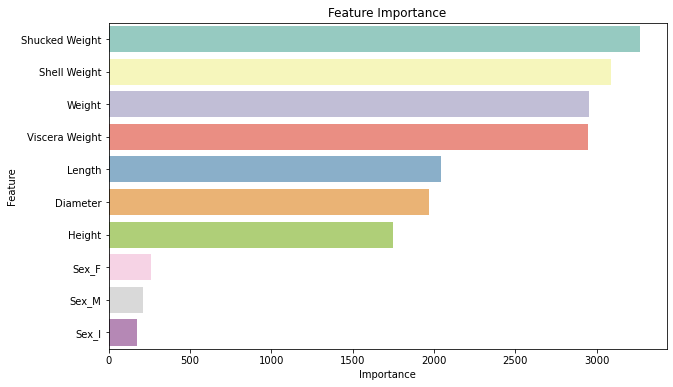

In [31]:

feature_importance = pd.DataFrame({'Feature': x.columns, 'Importance': final_model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='Set3')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()





In [24]:
predictions.head()

,id,Age
0,74051,8
1,74052,8
2,74053,11
3,74054,9
4,74055,7
